# Product Recommender System Using OpenAI API

Author: Stefanie Warum

In [15]:
import os
from openai import OpenAI
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial import distance
from adjustText import adjust_text

# Define the model to use
model = "gpt-4-turbo"
client = OpenAI(api_key=os.environ["OPENAI"])

In [16]:
# Import file with products
from products import products # List of all products
from last_product import last_product # Last product a user visited
from user_history import user_history # User purchase history (five products)
from user_history2 import user_history2 # User purchase history second example

In [3]:
# Example products
for product in products[:5]:
    print(f"{product['title']}: {product['price']}")

Ski Pass Alpine Valley: 65.0
Beginner Ski Lessons: 120.0
High-Performance Ski Set Rental: 35.0
Snow Festival Ticket: 45.0
Mountain Top Dining Experience: 150.0


## Create embeddings for product descriptions

In [19]:
# Extract a list of product short descriptions from products
product_descriptions = [product["short_description"] for product in products]

# Create embeddings for each product description
response = client.embeddings.create(
    model="text-embedding-ada-002",
    input=product_descriptions
)

response_dict = response.model_dump()

# Extract the embeddings from response_dict and store in products
for i, product in enumerate(products):
    product['embedding'] = response_dict["data"][i]["embedding"]

## Visualizing the embedded descriptions

Use t-SNE for dimensionality reduction and reducing the embeddings data from 1536 to e.g. 2, which will make the data more easily to visualize.

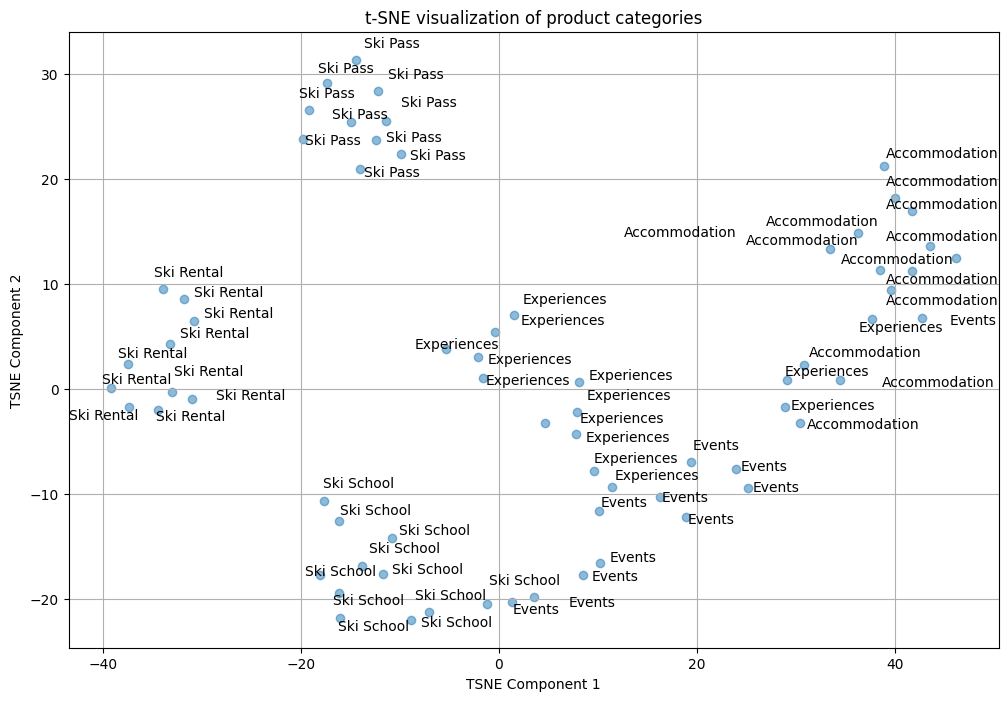

In [5]:
categories = [product['category'] for product in products]
embeddings = [product['embedding'] for product in products]

# Reduce the number of embeddings dimensions to two using t-SNE
tsne = TSNE(n_components=2, perplexity=5)
embeddings_2d = tsne.fit_transform(np.array(embeddings))

plt.figure(figsize=(12, 8)) # Create a larger plot to help with readability
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5) # Create a scatter plot from embeddings_2d

# Add annotations and use adjust_text to avoid overlap
texts = []
for i, category in enumerate(categories):
    texts.append(plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], category))

# Automatically adjust text positions
adjust_text(texts)

# Add grid and labels for clarity
plt.grid(True)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('t-SNE visualization of product categories')

plt.show()

## Custom functions for embeddings and distances



This function, find_n_closest, takes a query vector, a list of embeddings, and an optional parameter n indicating the number of closest embeddings to find (default is 3).

For each embedding in the list, it calculates the cosine distance between the query vector and the embedding. It then stores these distances along with their corresponding index in a list of dictionaries called distances.

After computing all distances, it sorts the distances list based on the distance values in ascending order using the sorted function with a lambda function as the key to sort by the "distance" key in each dictionary.

Finally, it returns the first n elements of the sorted distances list, representing the n closest embeddings to the query vector, along with their corresponding distances and indices.

Test the function for a search text "skirental" to retrieve closest entries in products.

In [6]:
def find_n_closest(query_vector, embeddings, n=3):
  distances = []
  for index, embedding in enumerate(embeddings):
    # Calculate the cosine distance between the query vector and embedding
    dist = distance.cosine(query_vector, embedding)
    # Append the distance and index to distances
    distances.append({"distance": dist, "index": index})
  # Sort distances by the distance key
  distances_sorted = sorted(distances, key=lambda x: x["distance"])
  # Return the first n elements in distances_sorted
  return distances_sorted[0:n]

In [7]:
# Define a create_embeddings function
def create_embeddings(texts):
  response = client.embeddings.create(
    model="text-embedding-ada-002",
    input=texts
  )
  response_dict = response.model_dump()
  
  return [data['embedding'] for data in response_dict['data']]

Test the embeddings function with a search example:

In [8]:
# Example search text to test function
search_text = "skirental"
search_embedding = create_embeddings(search_text)[0]

# Compute distances using find_n_closest function, limit to one response
closest_product = find_n_closest(search_embedding, [product["embedding"] for product in products], n=1)

# Print the most similar product short_description
index = closest_product[0]["index"]
print(products[index]["short_description"])

Special ski pass for young skiers under 18, with access to beginner and intermediate slopes.


# Recommender System for Products

Save features as a string and add to embeddings to improve recommendations.

In [35]:
# Define a function to combine the relevant features into a single string
def create_product_text(product):
  return f"""Title: {product["title"]}
Description: {product["short_description"]}
Category: {product["category"]}
Features: {", ".join(product["features"])}"""

### Provide recommenations for last product visited

In [36]:
# Combine the features for last_product and each product in products
last_product_text = create_product_text(last_product)
product_texts = [create_product_text(product) for product in products]

# Embed last_product_text and product_texts
last_product_embeddings = create_embeddings(last_product_text)[0]
product_embeddings = create_embeddings(product_texts)

# Find the three smallest cosine distances and their indexes
hits = find_n_closest(last_product_embeddings, product_embeddings)

for hit in hits:
  product = products[hit['index']]
  print(product['title'])

Full Season Ski Pass
Adventure Ski Pass
Ultimate Snow Experience Pass


### Provide recommendations based on a user's history

Example 1 for a user with the following history:

In [11]:
for user_history in user_history:
    print(f"{user_history['title']}: {user_history['price']}")

Mountain Top Dining Experience: 150.0
Luxury Ski-in/Ski-out Condo: 350.0
Snowboard Fun Lessons: 135.0
Helicopter Skiing Adventure: 500.0
Eco-Friendly Ski Lodge: 300.0


In [37]:
# Prepare and embed the user_history, and calculate the mean embeddings
history_texts = [create_product_text(product) for product in user_history]
history_embeddings = create_embeddings(history_texts)
mean_history_embeddings = np.mean(history_embeddings, axis=0)

# Filter products to remove any in user_history
products_filtered = [product for product in products if product not in user_history]

# Combine product features and embed the resulting texts
product_texts = [create_product_text(product) for product in products_filtered]
product_embeddings = create_embeddings(product_texts)

hits = find_n_closest(mean_history_embeddings, product_embeddings)

for hit in hits:
  product = products_filtered[hit['index']]
  print(product['title'])

Helicopter Skiing Adventure
Luxury Ski-in/Ski-out Condo
Eco-Friendly Ski Lodge


Example 2 for a user with the following history:

In [13]:
for user_history2 in user_history2:
    print(f"{user_history2['title']}: {user_history2['price']}")

Northern Lights Tour: 200.0
Deluxe Beachfront Villa: 450.0
Surfing Safari: 180.0
Yoga Retreat: 300.0
Safari Lodge: 400.0


In [38]:
# Prepare and embed the user_history, and calculate the mean embeddings
history_texts2 = [create_product_text(product) for product in user_history2]
history_embeddings2 = create_embeddings(history_texts2)
mean_history_embeddings2 = np.mean(history_embeddings2, axis=0)

# Filter products to remove any in user_history
products_filtered2 = [product for product in products if product not in user_history2]

# Combine product features and embed the resulting texts
product_texts2 = [create_product_text(product) for product in products_filtered2]
product_embeddings2 = create_embeddings(product_texts2)

hits2 = find_n_closest(mean_history_embeddings2, product_embeddings2)

for hit in hits2:
  product2 = products_filtered2[hit['index']]
  print(product2['title'])

Snowmobile Safari
Luxury Spa Retreat
Luxury Mountain Top Hotel
